In [11]:
using Revise
using HierarchicalDA
using LinearAlgebra
using Statistics
using Distributions
using StatsBase
using QuadGK
using Test

Precompiling HierarchicalDA
  ✓ HierarchicalDA
  1 dependency successfully precompiled in 7 seconds. 497 already precompiled.


In [12]:
using CairoMakie

In [13]:
μX = 0.1
σX = 0.2
πX = Normal(μX, σX)

Normal{Float64}(μ=0.1, σ=0.2)

In [14]:
xstar = 0.3

0.3

In [15]:
@testset "Test CRPS implementation" begin
    
    μX = 0.1
    σX = 0.2
    πX = Normal(μX, σX)

    xstar = 0.3

    X = rand(πX, 10000)

    @test isapprox(CRPS_gaussian(πX, xstar), CRPS_quadrature(X, xstar), atol =1e-2)
    @test isapprox(CRPS_gaussian(πX, xstar), CRPS(X, xstar), atol =1e-2)
end

Test Summary:            | Pass  Total  Time
Test CRPS implementation |    2      2  0.7s


Test.DefaultTestSet("Test CRPS implementation", Any[], 2, false, false, true, 1.717086759758041e9, 1.717086760486046e9, false, "In[15]")

In [194]:
function CRPS_gaussian(p::Normal{Float64}, x)
    μ = mean(p)
    σ = std(p)
    z = (x-μ)/σ
    return σ*(z*(2*cdf(Normal(), z) - 1) + 2*pdf(Normal(), z) - 1/sqrt(π))
end

CRPS_gaussian (generic function with 1 method)

In [195]:
function CRPS_quadrature(X, x)
    ΦX = ecdf(X)
    Φx = ecdf([x])
    return quadgk(x->(ΦX(x) - Φx(x))^2, -Inf, Inf)[1]
end

CRPS_quadrature (generic function with 1 method)

In [196]:
function CRPS_fast(X::Vector{Float64}, x::Float64)
    N = length(X)
    
    Xsort = sort(X)
    
    term1 = 0.0
    term2 = 0.0
    @inbounds for i=1:N
        xi = Xsort[i]
        term1 += abs(xi - x)
        for j=i+1:N
            xj = Xsort[j]
            term2 += 2*abs(xj - xi)
        end
    end
    
    term1 *= 1/N
    term2 *= 1/N^2
    
    return term1 - 0.5*term2
end

CRPS_fast (generic function with 1 method)

In [197]:
Xsort = sort(X);

In [198]:
function compute_crps(samples::Vector{Float64}, observed_value::Float64)
    N = length(samples)
    sorted_samples = sort(samples)
    
    # Compute the empirical CDF
    empirical_cdf = (1:N) / N
    
    # Compute the first term
    term1 = mean(abs.(sorted_samples .- observed_value))
    
    # Compute the second term
    term2 = mean(abs.(sorted_samples .- sorted_samples'))
    
    # CRPS calculation
    crps = term1 - 0.5 * term2
    
    return crps
end

compute_crps (generic function with 1 method)

In [199]:
@time CRPS_gaussian(πX, xstar)

  0.004026 seconds (4.11 k allocations: 270.312 KiB, 99.61% compilation time)


0.12048827152552327

In [200]:
X = rand(πX, 1000);

In [201]:
@time compute_crps(X, xstar)

  0.001074 seconds (7 allocations: 7.655 MiB)


0.1185019102255604

In [202]:
@time CRPS_quadrature(X, xstar)

  0.183676 seconds (465.77 k allocations: 30.415 MiB, 90.10% compilation time)


0.11850190266717606

In [203]:
@time CRPS_fast(X, xstar)

  0.000659 seconds (4 allocations: 18.188 KiB)


0.11850191022555867

In [166]:
function crps(observed_value::Float64, forecast_samples::Vector{Float64})
    forecast_samples_sorted = sort(forecast_samples) 
    n = length(forecast_samples_sorted)
    # Calculate the cumulative distribution function (CDF) of the forecast samples
    cdf_values = [sum(forecast_samples_sorted .<= obs) / n for obs in forecast_samples_sorted]
    
    # Compute the integral of the squared difference between CDF and a Heaviside step function
#     crps_value = mean([(cdf_values[i] - (forecast_samples[i] ≥ observed_value ))^2 for i in 1:n])
    
    return cdf_values
end

crps (generic function with 1 method)

In [167]:
crps(xstar, X)

1000-element Vector{Float64}:
 0.001
 0.002
 0.003
 0.004
 0.005
 0.006
 0.007
 0.008
 0.009
 0.01
 0.011
 0.012
 0.013
 ⋮
 0.989
 0.99
 0.991
 0.992
 0.993
 0.994
 0.995
 0.996
 0.997
 0.998
 0.999
 1.0

In [168]:
ΦX.(sort(X))

1000-element Vector{Float64}:
 0.35
 0.39
 0.41
 0.41
 0.41
 0.41
 0.41
 0.41
 0.41
 0.41
 0.41
 0.41
 0.41
 ⋮
 0.69
 0.69
 0.69
 0.69
 0.7
 0.7
 0.7
 0.7
 0.7
 0.7
 0.7
 0.74

In [45]:
@time 

  0.156024 seconds (1.01 M allocations: 29.547 MiB, 93.20% compilation time)


0.23625408779324372

In [61]:
fig = Figure()

ax = Axis(fig[1,1])

lines!(ax, -5.0:0.01:5.0, x-> crps(xstar, X))
lines!(ax, -5.0:0.01:5.0, x-> ecdf([0])(x))
    
fig

LoadError: `Makie.convert_arguments` for the plot type Lines and its conversion trait PointBased() was unsuccessful.

The signature that could not be converted was:
::Vector{Float32}, ::Vector{Vector{Float64}}

Makie needs to convert all plot input arguments to types that can be consumed by the backends (typically Arrays with Float32 elements).
You can define a method for `Makie.convert_arguments` (a type recipe) for these types or their supertypes to make this set of arguments convertible (See http://docs.makie.org/stable/documentation/recipes/index.html).

Alternatively, you can define `Makie.convert_single_argument` for single arguments which have types that are unknown to Makie but which can be converted to known types and fed back to the conversion pipeline.


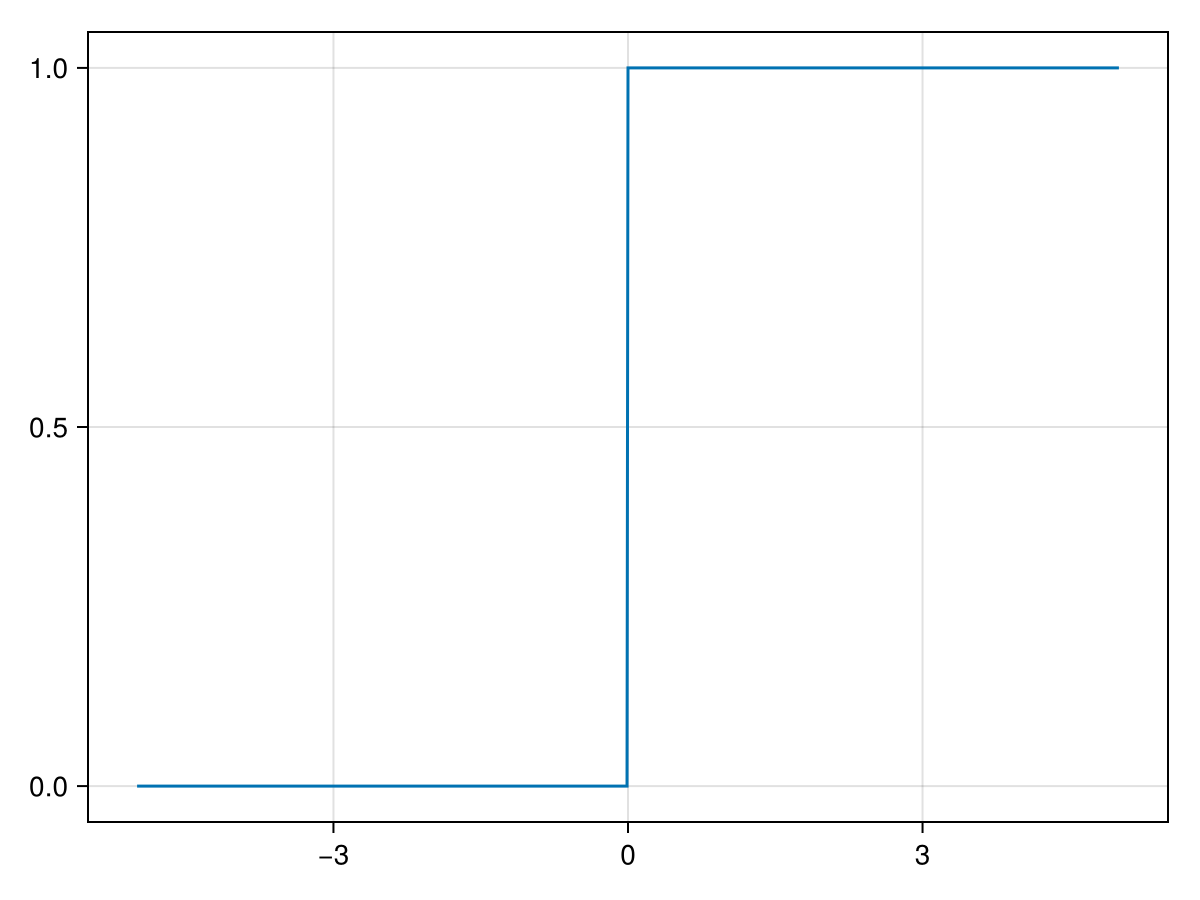

In [27]:
lines(-5.0:0.01:5.0, x-> ecdf([0])(x))